Royston Rex Fernandez - 201759033 <br>
Atshaya Srinivasan - 201774445

# Importing the libraries
We import all of the essential libraries first for data loading, processing, model training and performance evaluation

In [2]:
# Basic libraries for data processing and visualisation
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Importing Tensorflow libraries for deep learning algorithms
import tensorflow as tf
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout, Activation
from keras.optimizers import SGD, Adam, Adagrad
from keras.optimizers.schedules import ExponentialDecay, InverseTimeDecay
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


# Importing sci-kit learn packages for validation and evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# Suppressing unwanted warnings
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Loading the dataset

In [3]:
# Load the EMNIST Balanced dataset using pandas
train_path = "emnist-balanced-train.csv"
test_path = "emnist-balanced-test.csv"

train_df = pd.read_csv(train_path, header=None)
test_df = pd.read_csv(test_path, header=None)

# Extract train and test data
x_train = train_df.iloc[:, 1:].values
x_test = test_df.iloc[:, 1:].values
y_train = train_df.iloc[:, 0].values
y_test = test_df.iloc[:, 0].values

# We encode the labels as one-hot encoding as the neural network has a softmax activation
one_hot_y_train = to_categorical(y_train, num_classes=47)
one_hot_y_test = to_categorical(y_test, num_classes=47)

# Normalize the pixel values to be between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# Reshape the images
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

# Print the number of training and testing samples
print(f"Number of training samples: {len(x_train)}")
print(f"Number of testing samples: {len(x_test)}")

# Read the mapping from the text file using pandas
class_mapping_file = "emnist-balanced-mapping.txt"
class_mapping_df = pd.read_csv(class_mapping_file, sep=' ', header=None, names=['Class Label', 'Character'])
class_mapping = dict(zip(class_mapping_df['Class Label'], class_mapping_df['Character']))

Number of training samples: 112800
Number of testing samples: 18800


# Plotting the images

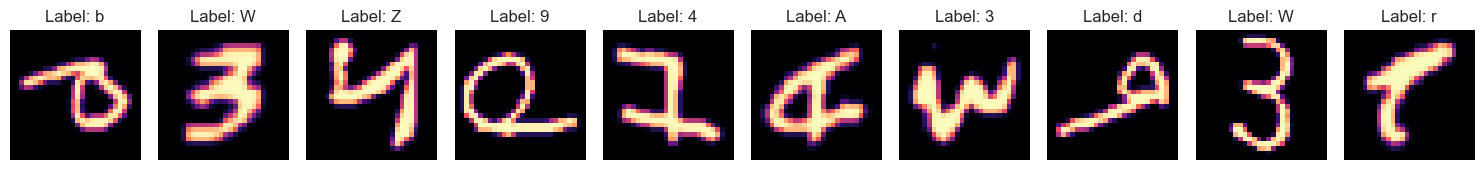

In [101]:
def plot_images(images, labels, class_mapping, num_images=10):
    """
    Plots a specified number of images along with their corresponding labels.

    Parameters:
        images (numpy.ndarray): Array of image data. Each image should be represented as a 1D array.
        labels (numpy.ndarray): Array of labels corresponding to the images.
        class_mapping (dict): A dictionary mapping label indices to their corresponding characters.
        num_images (int): Number of images to plot. Default is 10.

    Returns:
        None
    """
    # Generate random indices to select random samples
    indices = np.random.choice(len(images), num_images, replace=False)
    
    # Create subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    
    # Plot each image and its corresponding label
    for i, idx in enumerate(indices):
        ax = axes[i]
        image = images[idx].reshape(28, 28)  # Reshape image to 28x28
        label_index = labels[idx]
        label = chr(class_mapping[label_index]) # Converts the ASCI mapping to characters
        ax.imshow(image, cmap='magma')
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_images(x_train, y_train, class_mapping)

# Model Initialisation and Compilation
### Our first baseline model is created using the below parameters for both MLP and CNN:

For MLP the base model has the below parameters:-
1) Activation function is ReLu
2) Optimizer is SGD
3) No batch Normalisation
4) Regularisation is None
5) No Dropout
6) No Learning Rate Scheduler

For CNN the base model has the below parameters:-
1) Activation function is ReLu
2) Optimizer is AdaGrad
3) No batch Normalisation
4) Regularisation is None
5) No Dropout
6) Learning Rate Scheduler is Exponential Decay

In [26]:
# Base MLP Model
def create_mlp(num_classes,optimizer='sgd', activation='relu', 
               learning_rate_scheduler=None, regularizer=None,
               use_dropout=False, use_batch_norm=False):
    """
    Creates a Multi-Layer Perceptron (MLP) model with configurable options.

    Parameters:
        num_classes (int): Number of classes in the classification task.
        optimizer (str): Name of the optimizer to use. Options: 'adam', 'sgd', 'adagrad'. Default is 'adam'.
        activation (str): Activation function to use in hidden layers. Default is 'tanh'.
        learning_rate_scheduler (str): Learning rate scheduler type. Options: 'exp' (exponential), 'invdecay' (inverse decay), None (no scheduler). Default is None.
        regularizer (tensorflow.keras.regularizers.Regularizer): Regularization function. Default is None.
        use_dropout (bool): Whether to use dropout regularization. Default is False.
        use_batch_norm (bool): Whether to use batch normalization. Default is False.

    Returns:
        tensorflow.keras.models.Sequential: Compiled MLP model.
    """
    model = Sequential()
    # Flatten input layer
    model.add(Flatten(input_shape=x_train[0].shape)) 
    
    # Hidden layers 1
    model.add(Dense(128, kernel_regularizer=regularizer))
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(Activation(activation))
    if use_dropout:
        model.add(Dropout(0.2))
        
    # Hidden layers 2
    model.add(Dense(64, kernel_regularizer=regularizer))
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(Activation(activation))
    if use_dropout:
        model.add(Dropout(0.2))
    
    # Hidden layers 3
    model.add(Dense(64, kernel_regularizer=regularizer))
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(Activation(activation))
    if use_dropout:
        model.add(Dropout(0.2))

    # Ouput Layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Configure learning rate scheduler
    if learning_rate_scheduler == 'exp':
        learning_rate = ExponentialDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.96)
    elif learning_rate_scheduler == 'invdecay':
        learning_rate = InverseTimeDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.5)
    elif learning_rate_scheduler == None:
        learning_rate = 0.01
    
    # Configure optimizer
    if optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [41]:
def create_cnn(num_classes, optimizer='adagrad', activation='relu',
               learning_rate_scheduler='exp', regularizer=None,
               use_dropout=False, use_batch_norm=False):
    """
    Creates a Convolutional Neural Network (CNN) model with configurable options.

    Parameters:
        num_classes (int): Number of classes in the classification task.
        optimizer (str): Name of the optimizer to use. Options: 'adam', 'sgd', 'adagrad'. Default is 'adam'.
        activation (str): Activation function to use in convolutional and dense layers. Default is 'tanh'.
        learning_rate_scheduler (str): Learning rate scheduler type. Options: 'exp' (exponential), 'invdecay' (inverse decay), None (no scheduler). Default is 'exp'.
        regularizer (tensorflow.keras.regularizers.Regularizer): Regularization function. Default is None.
        use_dropout (bool): Whether to use dropout regularization. Default is False.
        use_batch_norm (bool): Whether to use batch normalization. Default is False.

    Returns:
        tensorflow.keras.models.Sequential: Compiled CNN model.
    """
    model = Sequential()
    
    # Convolutional layers 1
    model.add(Conv2D(32, kernel_size=(3, 3), kernel_regularizer=regularizer,input_shape=x_train[0].shape))
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if use_dropout:
        model.add(Dropout(0.25))
    
    # Convolutional layers 2
    model.add(Conv2D(64, kernel_size=(3, 3), kernel_regularizer=regularizer))
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if use_dropout:
        model.add(Dropout(0.25))
    
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(128, kernel_regularizer=regularizer))
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(Activation(activation))
    if use_dropout:
        model.add(Dropout(0.5))
    
    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Configure learning rate scheduler
    if learning_rate_scheduler == 'exp':
        learning_rate = ExponentialDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.96)
    elif learning_rate_scheduler == 'invdecay':
        learning_rate = InverseTimeDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.5)
    elif learning_rate_scheduler == None:
        learning_rate = 0.01

    # Configure optimizer
    if optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# MLP
## Model Training
We then train our base MLP model on the training dataset and validate against a predefined validation set which is the last 20% of the training data.

In [27]:
# Build and Train MLP Model
mlp_base = create_mlp(num_classes=len(np.unique(y_train)))
mlp_base_history = mlp_base.fit(x_train, one_hot_y_train, epochs=10, batch_size=47, validation_split=0.2, verbose=1)

Epoch 1/10
1920/1920 [==============================] - 8s 4ms/step - loss: 2.6979 - accuracy: 0.3130 - val_loss: 1.5342 - val_accuracy: 0.5687
Epoch 2/10
1920/1920 [==============================] - 6s 3ms/step - loss: 1.3379 - accuracy: 0.6226 - val_loss: 1.1801 - val_accuracy: 0.6595
Epoch 3/10
1920/1920 [==============================] - 7s 3ms/step - loss: 1.0980 - accuracy: 0.6829 - val_loss: 1.0252 - val_accuracy: 0.6953
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/step - loss: 0.9652 - accuracy: 0.7155 - val_loss: 0.9135 - val_accuracy: 0.7242
Epoch 5/10
1920/1920 [==============================] - 7s 4ms/step - loss: 0.8733 - accuracy: 0.7386 - val_loss: 0.8470 - val_accuracy: 0.7430
Epoch 6/10
1920/1920 [==============================] - 7s 4ms/step - loss: 0.8051 - accuracy: 0.7561 - val_loss: 0.7878 - val_accuracy: 0.7552
Epoch 7/10
1920/1920 [==============================] - 7s 3ms/step - loss: 0.7524 - accuracy: 0.7694 - val_loss: 0.7439 - val_accuracy:

In [66]:
# Get validation accuracy and loss of the base model
final_mlp_val_accuracy = mlp_base_history.history['val_accuracy'][-1]
final_mlp_val_loss = mlp_base_history.history['val_loss'][-1]

print("Accuracy of Base MLP Model:", final_mlp_val_accuracy)
print("Loss of Base MLP Model:", final_mlp_val_loss)

Accuracy of Base MLP Model: 0.7831116914749146
Loss of Base MLP Model: 0.6832437515258789


## Exploring Different Hyperparameter Combinations 
Now we fine tune different hyperparameters to make our baseline model more efficient and accurate by exploring different techniques. We define a dictionary to store these parameters, so that the optimization function can iteratively fine tune our models. We then use a validation dataset to validate our training results to find the best parameters for our model.


In [29]:
# Tunable parameters
hyperparameter_dict = {
    "activation": ['relu', 'elu', 'tanh'],
    "optimizer": ['sgd', 'adam', 'adagrad'],
    "learning_rate_scheduler": ["exp", "invdecay"],
    'regularizer': [regularizers.l1(0.01), regularizers.l2(0.01), None],
    "use_dropout": [True, False],
    "use_batch_norm": [True, False],
}

 We use a strategy where we start with a baseline configuration and progressively refine the model through systematic investigation and evaluation of activation functions, optimizers, regularization methods, and learning rate scheduling while preserving the most effective settings from previous explorations.

In [30]:
def optimize_hyperparameters(hyperparameter_dict, x_train, one_hot_y_train, model_name):
    """
    Optimizes hyperparameters for a given model.

    Parameters:
        hyperparameter_dict (dict): Dictionary containing hyperparameters to tune and their respective values.
        x_train (numpy.ndarray): Training data.
        one_hot_y_train (numpy.ndarray): One-hot encoded labels for training data.
        model_name (str): Name of the model to optimize hyperparameters for. Options: 'mlp' or 'cnn'.

    Returns:
        tuple: A tuple containing the best hyperparameters and the corresponding best accuracy.
    """
    # Start the timer
    startTime = time.time()
    
    best_params = {}
    best_accuracy = 0  
    # Iterate through each hyperparameter in the grid
    for hyperparameter, values in hyperparameter_dict.items(): 
 
        for value in values:
            # Print loop progress
            print(f"Processing combination: {hyperparameter}={value}")
            val_accuracies = []
            
            if model_name == 'mlp':
                # Create and compile the MLP model with current hyperparameters
                model = create_mlp(num_classes=len(np.unique(y_train)), **best_params)
            elif model_name == 'cnn':
                # Create and compile the CNN model with current hyperparameters
                model = create_cnn(num_classes=len(np.unique(y_train)), **best_params)
            
            # Define EarlyStopping callback which monitors the validation loss
            early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            
            # Train the model (consider using early stopping for efficiency)
            model_history = model.fit(x_train, one_hot_y_train, epochs=10, batch_size=47, validation_split=0.2, verbose=2, callbacks=[early_stopping])

            # Evaluate the model on validation set and calculate accuracy
            val_accuracy = model_history.history['val_accuracy'][-1]
            val_accuracies.append(val_accuracy)
            avg_val_accuracy = np.mean(val_accuracies)
            
            # Update best hyperparameters if current combination performs better
            if avg_val_accuracy > best_accuracy:
                best_accuracy = avg_val_accuracy
                # Update best_params only if current combination is better
                best_params = {**best_params, hyperparameter: value}  # Update with dictionary comprehension
        
        # Print the current best hyperparameter
        print(f"Best Accuracy of {hyperparameter}: {best_accuracy}")
        print(f"Best Hyperparameters:")
        for key, value in best_params.items():
            print(f"\t- {key}: {value}")

    # End the timer and compute the total training time
    endTime = time.time()
    trainingTime = endTime - startTime
    
    return best_params, best_accuracy, trainingTime

We now then train the model on the tunable hyperparameters to get the best MLP model

In [31]:
# Fine tuning the parameters
best_mlp_params, best_mlp_accuracy, time = optimize_hyperparameters(hyperparameter_dict, x_train, one_hot_y_train, model_name='mlp')

Processing combination: activation=relu
Epoch 1/10
1920/1920 - 8s - loss: 2.7761 - accuracy: 0.2917 - val_loss: 1.6142 - val_accuracy: 0.5477 - 8s/epoch - 4ms/step
Epoch 2/10
1920/1920 - 6s - loss: 1.3810 - accuracy: 0.6066 - val_loss: 1.2027 - val_accuracy: 0.6553 - 6s/epoch - 3ms/step
Epoch 3/10
1920/1920 - 5s - loss: 1.1201 - accuracy: 0.6761 - val_loss: 1.0346 - val_accuracy: 0.6993 - 5s/epoch - 3ms/step
Epoch 4/10
1920/1920 - 5s - loss: 0.9768 - accuracy: 0.7132 - val_loss: 0.9271 - val_accuracy: 0.7241 - 5s/epoch - 3ms/step
Epoch 5/10
1920/1920 - 5s - loss: 0.8796 - accuracy: 0.7398 - val_loss: 0.8461 - val_accuracy: 0.7433 - 5s/epoch - 3ms/step
Epoch 6/10
1920/1920 - 11s - loss: 0.8080 - accuracy: 0.7574 - val_loss: 0.7908 - val_accuracy: 0.7574 - 11s/epoch - 6ms/step
Epoch 7/10
1920/1920 - 11s - loss: 0.7526 - accuracy: 0.7725 - val_loss: 0.7384 - val_accuracy: 0.7729 - 11s/epoch - 6ms/step
Epoch 8/10
1920/1920 - 11s - loss: 0.7090 - accuracy: 0.7827 - val_loss: 0.7107 - val_ac

The final loop will get us all the best parameters for our model apart from the predefined baseline parameters.

In [32]:
# Print the best parameters
print(f"Accuracy of Optimised Model: {best_mlp_accuracy}")
print(f"Best Hyperparameters:")
for key, value in best_mlp_params.items():
    print(f"\t- {key}: {value}")
print(f"Total training time: {time}")

Accuracy of Optimised Model: 0.7914893627166748
Best Hyperparameters:
	- activation: tanh
Total training time: 1147.6766772270203


### Training the model with the best hyperparameter that was explored
Now we train with these best parameters to get out best MLP model.

In [37]:
# Training with best params
best_mlp = create_mlp(num_classes=len(np.unique(y_train)), **best_mlp_params)
best_mlp_history = best_mlp.fit(x_train, one_hot_y_train, epochs=10, batch_size=47, validation_split=0.2, verbose=1)

Epoch 1/10
1920/1920 [==============================] - 9s 4ms/step - loss: 2.5675 - accuracy: 0.4014 - val_loss: 1.8754 - val_accuracy: 0.5476
Epoch 2/10
1920/1920 [==============================] - 7s 4ms/step - loss: 1.6250 - accuracy: 0.5927 - val_loss: 1.4405 - val_accuracy: 0.6227
Epoch 3/10
1920/1920 [==============================] - 7s 4ms/step - loss: 1.3306 - accuracy: 0.6478 - val_loss: 1.2392 - val_accuracy: 0.6629
Epoch 4/10
1920/1920 [==============================] - 7s 4ms/step - loss: 1.1676 - accuracy: 0.6804 - val_loss: 1.1094 - val_accuracy: 0.6905
Epoch 5/10
1920/1920 [==============================] - 5s 3ms/step - loss: 1.0533 - accuracy: 0.7038 - val_loss: 1.0119 - val_accuracy: 0.7121
Epoch 6/10
1920/1920 [==============================] - 7s 4ms/step - loss: 0.9654 - accuracy: 0.7231 - val_loss: 0.9351 - val_accuracy: 0.7300
Epoch 7/10
1920/1920 [==============================] - 7s 4ms/step - loss: 0.8948 - accuracy: 0.7401 - val_loss: 0.8760 - val_accuracy:

## Save the MLP model 

In [39]:
# Saving the MLP model
best_mlp.save("mlp_model.h5", overwrite=True)

## Plotting the training graph
Lets plot the learing graph to check for underfitting or overfitting

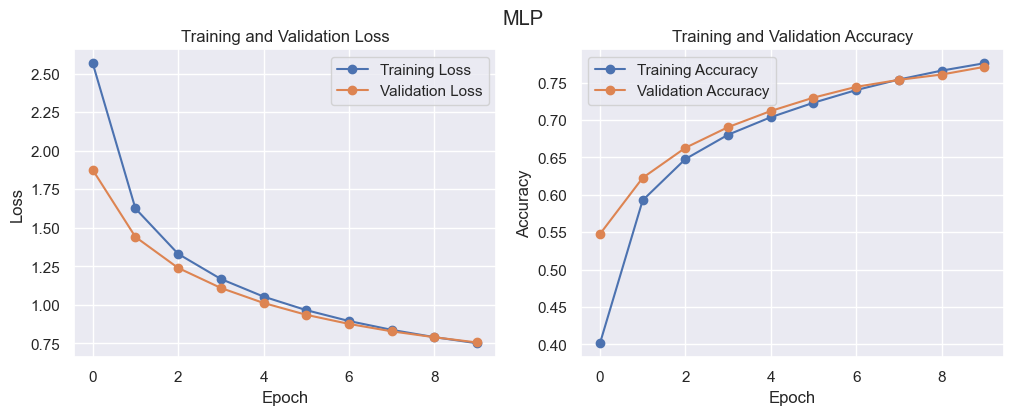

In [38]:
def plot_loss_and_accuracy(model_history, model_name):
    """
    Plots the training and validation loss, as well as training and validation accuracy, from a given model's training history.

    Parameters:
        model_history (History): History object returned by the `fit` method of a Keras model, containing training metrics.
        model_name (str): Name of the model to be displayed as the title of the plot.

    Returns:
        None
    """
    plt.figure(figsize=(12, 4))
    plt.suptitle(model_name)

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['loss'], '-o', label='Training Loss')
    plt.plot(model_history.history['val_loss'], '-o', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['accuracy'], '-o', label='Training Accuracy')
    plt.plot(model_history.history['val_accuracy'], '-o', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
plot_loss_and_accuracy(best_mlp_history, 'MLP')

# CNN
### We now follow the exact steps as we did for MLP, to find the best hyperparameters by fine tuning them for our CNN model

In [48]:
# Build and Train CNN Base Model
cnn_base = create_cnn(num_classes=len(np.unique(y_train)))
cnn_base_history = cnn_base.fit(x_train, one_hot_y_train, epochs=10, batch_size=47, validation_split=0.2, verbose=1)


Epoch 1/10
1920/1920 [==============================] - 79s 41ms/step - loss: 1.0478 - accuracy: 0.6834 - val_loss: 0.9789 - val_accuracy: 0.7027
Epoch 2/10
1920/1920 [==============================] - 70s 36ms/step - loss: 0.9794 - accuracy: 0.7080 - val_loss: 0.9010 - val_accuracy: 0.7233
Epoch 3/10
1920/1920 [==============================] - 64s 34ms/step - loss: 0.9695 - accuracy: 0.7101 - val_loss: 0.9222 - val_accuracy: 0.7241
Epoch 4/10
1920/1920 [==============================] - 54s 28ms/step - loss: 0.9545 - accuracy: 0.7140 - val_loss: 0.9919 - val_accuracy: 0.7047
Epoch 5/10
1920/1920 [==============================] - 56s 29ms/step - loss: 0.9324 - accuracy: 0.7177 - val_loss: 1.0691 - val_accuracy: 0.6913
Epoch 6/10
1920/1920 [==============================] - 59s 31ms/step - loss: 0.9430 - accuracy: 0.7151 - val_loss: 0.9994 - val_accuracy: 0.6997
Epoch 7/10
1920/1920 [==============================] - 57s 30ms/step - loss: 0.9248 - accuracy: 0.7217 - val_loss: 0.8978 

In [68]:
# Get validation accuracy and loss from history object
final_cnn_val_accuracy = cnn_base_history.history['val_accuracy'][-1]
final_cnn_val_loss = cnn_base_history.history['val_loss'][-1]

print("Accuracy of Base CNN Model:", final_cnn_val_accuracy)
print("Loss of Base CNN Model:", final_cnn_val_loss)

Accuracy of Base CNN Model: 0.7175
Loss of Base CNN Model: 0.9323


### Hyperparameter Tuning
Now we fine tune our CNN base model by exploring different techniques

In [70]:
# Tuning the hyperparameter
best_cnn_params, best_cnn_accuracy, time = optimize_hyperparameters(hyperparameter_dict, x_train, one_hot_y_train, model_name='cnn')

Processing combination: activation=relu
Epoch 1/10
1920/1920 - 25s - loss: 2.6530 - accuracy: 0.6384 - val_loss: 1.4726 - val_accuracy: 0.7655 - 25s/epoch - 13ms/step
Epoch 2/10
1920/1920 - 30s - loss: 1.2305 - accuracy: 0.7867 - val_loss: 1.0791 - val_accuracy: 0.7975 - 30s/epoch - 16ms/step
Epoch 3/10
1920/1920 - 37s - loss: 1.0112 - accuracy: 0.8093 - val_loss: 0.9657 - val_accuracy: 0.8128 - 37s/epoch - 19ms/step
Epoch 4/10
1920/1920 - 30s - loss: 0.9348 - accuracy: 0.8204 - val_loss: 0.9290 - val_accuracy: 0.8144 - 30s/epoch - 16ms/step
Epoch 5/10
1920/1920 - 41s - loss: 0.8947 - accuracy: 0.8276 - val_loss: 0.8890 - val_accuracy: 0.8262 - 41s/epoch - 21ms/step
Epoch 6/10
1920/1920 - 40s - loss: 0.8700 - accuracy: 0.8325 - val_loss: 0.8766 - val_accuracy: 0.8274 - 40s/epoch - 21ms/step
Epoch 7/10
1920/1920 - 38s - loss: 0.8528 - accuracy: 0.8355 - val_loss: 0.8701 - val_accuracy: 0.8258 - 38s/epoch - 20ms/step
Epoch 8/10
1920/1920 - 39s - loss: 0.8394 - accuracy: 0.8386 - val_loss

In [69]:
# Print the best params
print(f"Accuracy of Optimised Model: {best_cnn_accuracy}")
print(f"Best Hyperparameters:")
for key, value in best_cnn_params.items():
    print(f"\t- {key}: {value}")
print(f"Total training time: {time}")

Accuracy of Optimised Model: 0.8355053067207336
Best Hyperparameters:
	- activation: relu
Total training time: 4742.093411207199


We train the CNN model with these parameters

In [44]:
# Train with the best params
best_cnn = create_cnn(num_classes=len(np.unique(y_train)), **best_cnn_params)
best_cnn_history = best_cnn.fit(x_train, one_hot_y_train, epochs=10, batch_size=47, validation_split=0.2, verbose=1)

Epoch 1/10
1920/1920 [==============================] - 30s 15ms/step - loss: 1.3437 - accuracy: 0.6175 - val_loss: 0.7202 - val_accuracy: 0.7746
Epoch 2/10
1920/1920 [==============================] - 51s 27ms/step - loss: 0.6235 - accuracy: 0.8014 - val_loss: 0.5740 - val_accuracy: 0.8111
Epoch 3/10
1920/1920 [==============================] - 45s 24ms/step - loss: 0.5228 - accuracy: 0.8295 - val_loss: 0.5200 - val_accuracy: 0.8299
Epoch 4/10
1920/1920 [==============================] - 44s 23ms/step - loss: 0.4731 - accuracy: 0.8442 - val_loss: 0.4944 - val_accuracy: 0.8352
Epoch 5/10
1920/1920 [==============================] - 44s 23ms/step - loss: 0.4395 - accuracy: 0.8535 - val_loss: 0.4656 - val_accuracy: 0.8440
Epoch 6/10
1920/1920 [==============================] - 46s 24ms/step - loss: 0.4168 - accuracy: 0.8594 - val_loss: 0.4502 - val_accuracy: 0.8465
Epoch 7/10
1920/1920 [==============================] - 45s 23ms/step - loss: 0.3970 - accuracy: 0.8660 - val_loss: 0.4406 -

## Save the CNN model

In [45]:
# Saving the CNN Model
best_cnn.save("cnn_model.h5", overwrite=True)

## Plotting the training results

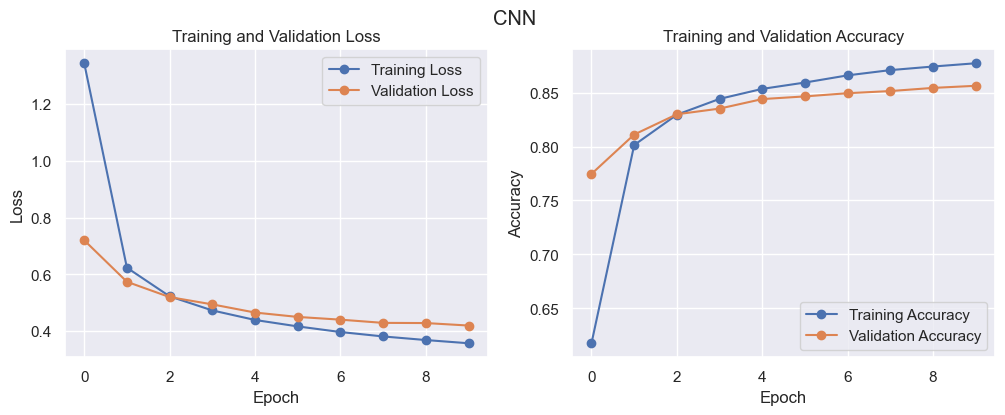

In [46]:
plot_loss_and_accuracy(best_cnn_history, 'CNN')

# Results
### Now that we have recieved the best of the two models, we can now evaluate these models on the testing dataset

In [51]:
# Load MLP and CNN models
best_mlp = load_model('mlp_model.h5')
best_cnn = load_model('cnn_model.h5')

We evaluate both the models to get the loss and accuracy

In [52]:
mlp_result = best_mlp.evaluate(x_test, one_hot_y_test)
cnn_result = best_cnn.evaluate(x_test, one_hot_y_test)

588/588 [==============================] - 4s 6ms/step - loss: 0.4404 - accuracy: 0.8559


We predict the labels of the test data set

In [53]:
# Make predictions using both models
mlp_pred = best_mlp.predict(x_test, verbose=1)
cnn_pred = best_cnn.predict(x_test, verbose=1)

588/588 [==============================] - 3s 6ms/step


## Predicted Results
Let us now visualise the predicted and actual labels

In [81]:
def pred_images(x_test, y_test, predicted_labels, class_mapping, model, num_images=6):
    """
    Plots a specified number of images from the test set along with their true and predicted labels.

    Parameters:
        x_test (numpy.ndarray): Array of test images.
        y_test (numpy.ndarray): Array of true labels corresponding to the test images.
        predicted_labels (numpy.ndarray): Array of predicted labels for the test images.
        class_mapping (dict): A dictionary mapping label indices to their corresponding characters.
        model (str): Name or identifier of the model used for predictions, displayed as the title of the plot.
        num_images (int): Number of images to plot. Default is 5.

    Returns:
        None
    """
    # Generate indices for first 6 samples
    indices = list(range(0, 6))
    
    # Create subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    
    # Plot each image with true and predicted labels
    for i, idx in enumerate(indices):
        ax = axes[i]
        image = x_test[idx].reshape(28, 28)  # Reshape image to 28x28
        true_label_index = y_test[idx]
        true_label = class_mapping[true_label_index]
        predicted_label_index = predicted_labels[idx]
        predicted_label = class_mapping[predicted_label_index] 
        ax.imshow(image, cmap='magma')
        fig.suptitle(model)
        # Plots the class labels and predicted labels
        ax.set_title(f"True Label: {chr(true_label)} ({true_label})\nPredicted Label: {chr(predicted_label)} ({predicted_label})")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

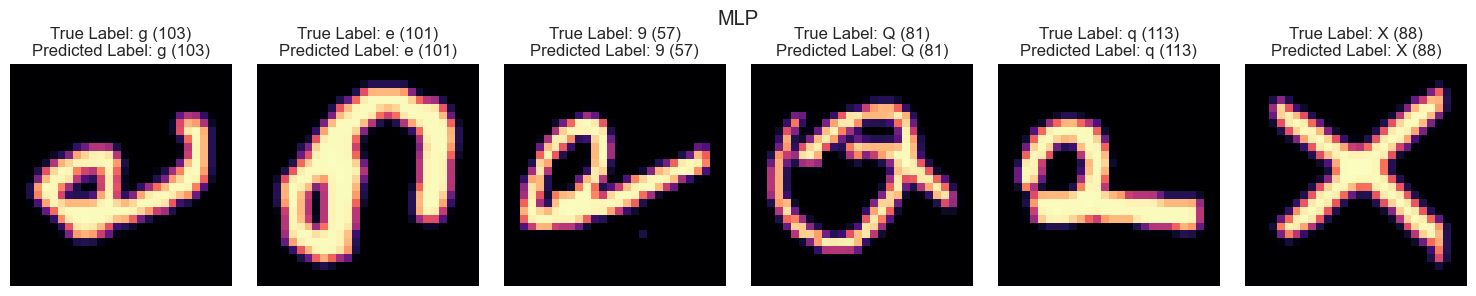

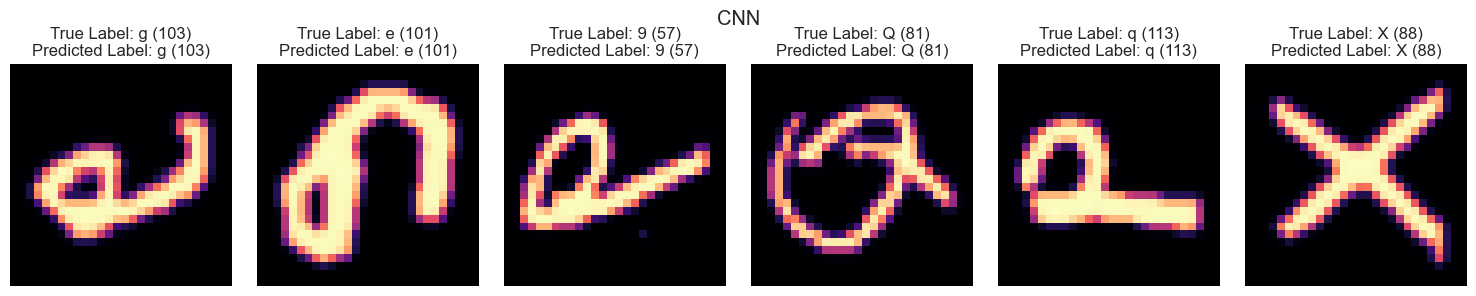

In [80]:
# Converts one hot encoded predictions to class lables
mlp_pred_indices = np.argmax(mlp_pred, axis=1)
cnn_pred_indices = np.argmax(cnn_pred, axis=1)

# Plot images with true labels and model predicted labels
pred_images(x_test, y_test, mlp_pred_indices, class_mapping, model='MLP')
pred_images(x_test, y_test, cnn_pred_indices, class_mapping, model='CNN')


## Summary of the results
We now calcuate the final perfomance metrics of the two models

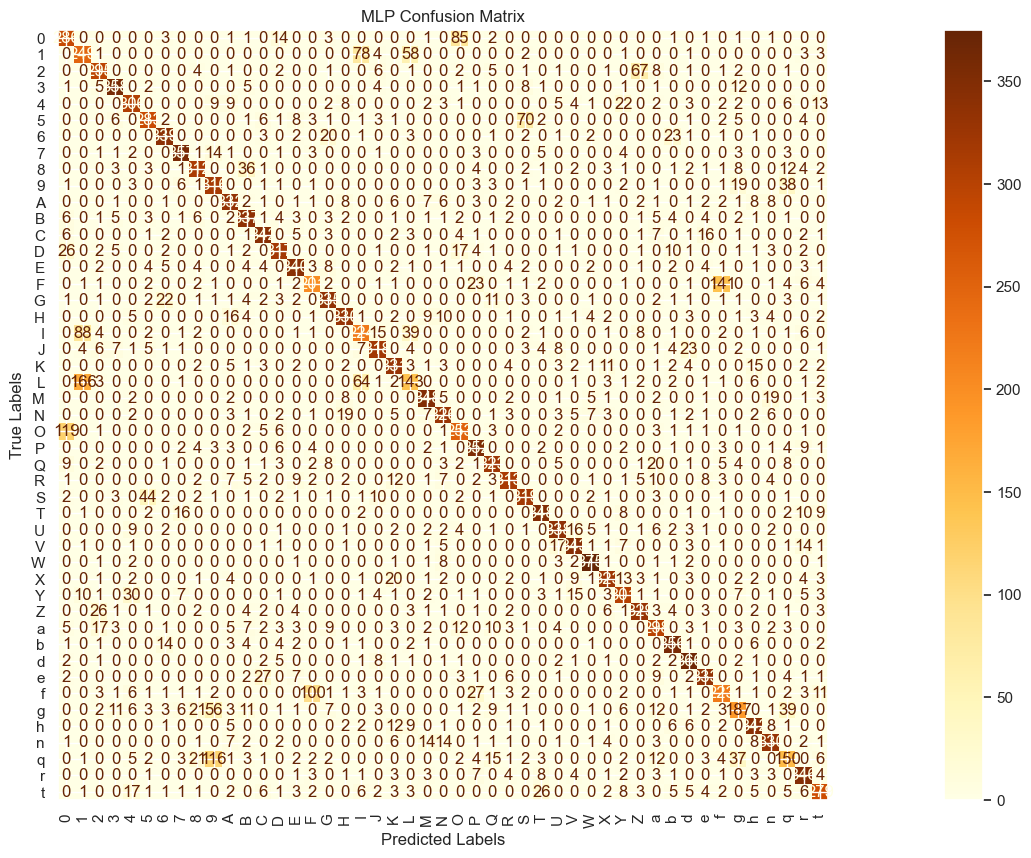

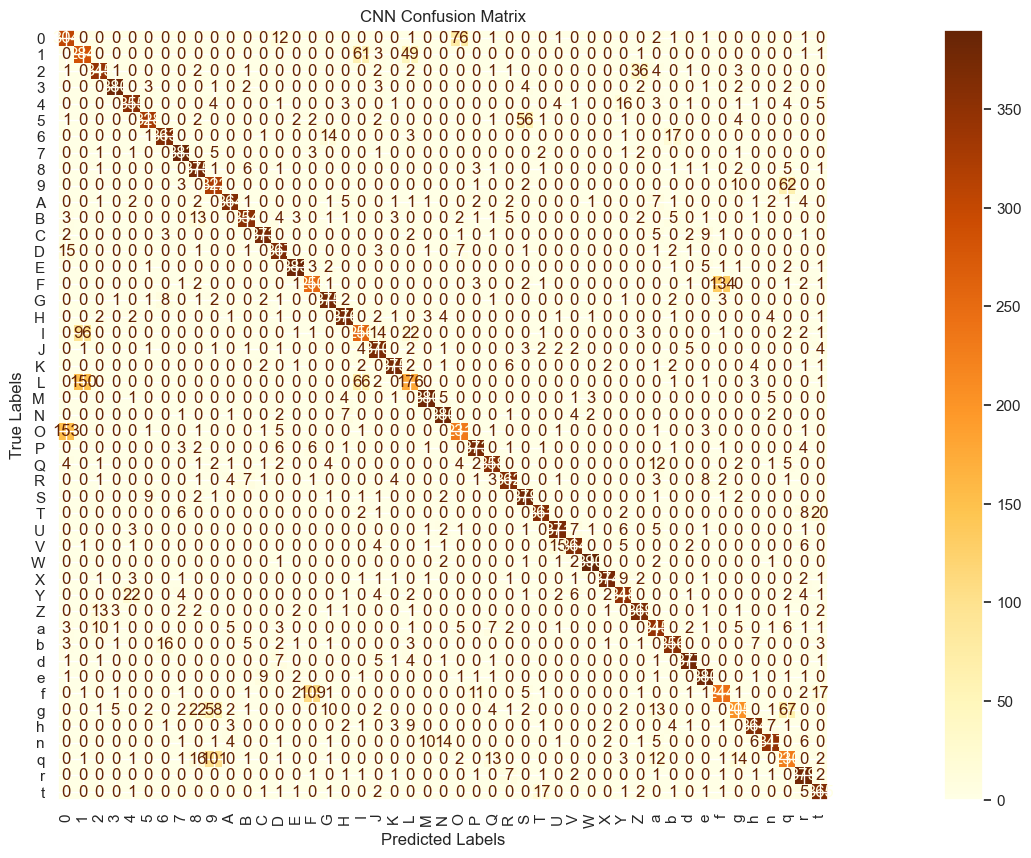

In [59]:
def plot_confusion_matrix(y_test, y_pred, title, class_mapping):
    """
    Plots a confusion matrix using ConfusionMatrixDisplay.

    Parameters:
        y_test (numpy.ndarray): True labels.
        y_pred (numpy.ndarray): Predicted labels.
        title (str): Title of the plot.
        class_mapping (dict): A dictionary mapping label indices to their corresponding characters.

    Returns:
        None
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Create ConfusionMatrixDisplay object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_mapping.values())
    
    plt.figure(figsize=(30, 10))
    disp.plot(cmap='YlOrBr', ax=plt.gca())
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    
    # Convert numeric indices to ASCII characters for xticks and yticks
    xtick_labels = [chr(class_mapping[i]) for i in range(len(class_mapping))]
    ytick_labels = [chr(class_mapping[i]) for i in range(len(class_mapping))]
    
    # Plotting class labels on the ticks
    plt.xticks(ticks=range(len(class_mapping)), labels=xtick_labels, rotation=90)
    plt.yticks(ticks=range(len(class_mapping)), labels=ytick_labels)
    plt.show()

# Plot confusion matrices for MLP and CNN models with class labels
plot_confusion_matrix(y_test, mlp_pred_indices, title='MLP Confusion Matrix', class_mapping=class_mapping)
plot_confusion_matrix(y_test, cnn_pred_indices, title='CNN Confusion Matrix', class_mapping=class_mapping)

We calculate accuracy, precision, recall and f1-score

In [60]:
def calculate_metrics(model_name, y_test, y_pred):
    """
    Calculates evaluation metrics (accuracy, precision, recall, F1 score) for a given model's predictions.

    Parameters:
        model_name (str): Name or identifier of the model.
        y_test (numpy.ndarray): True labels.
        y_pred (numpy.ndarray): Predicted labels.

    Returns:
        dict: A dictionary containing the calculated metrics.
    """
    # Calculate accuracy, precision, recall and f-score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Return metrics as a dictionary
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Calculate metrics for MLP model
mlp_metrics = calculate_metrics('MLP', y_test, mlp_pred_indices)

# Calculate metrics for CNN model
cnn_metrics = calculate_metrics('CNN', y_test, cnn_pred_indices)

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame([mlp_metrics, cnn_metrics])

In [65]:
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score
0,MLP,0.768723,0.767785,0.768723,0.766340
1,CNN,0.855851,0.858535,0.855851,0.854928


Visualising the metrics 

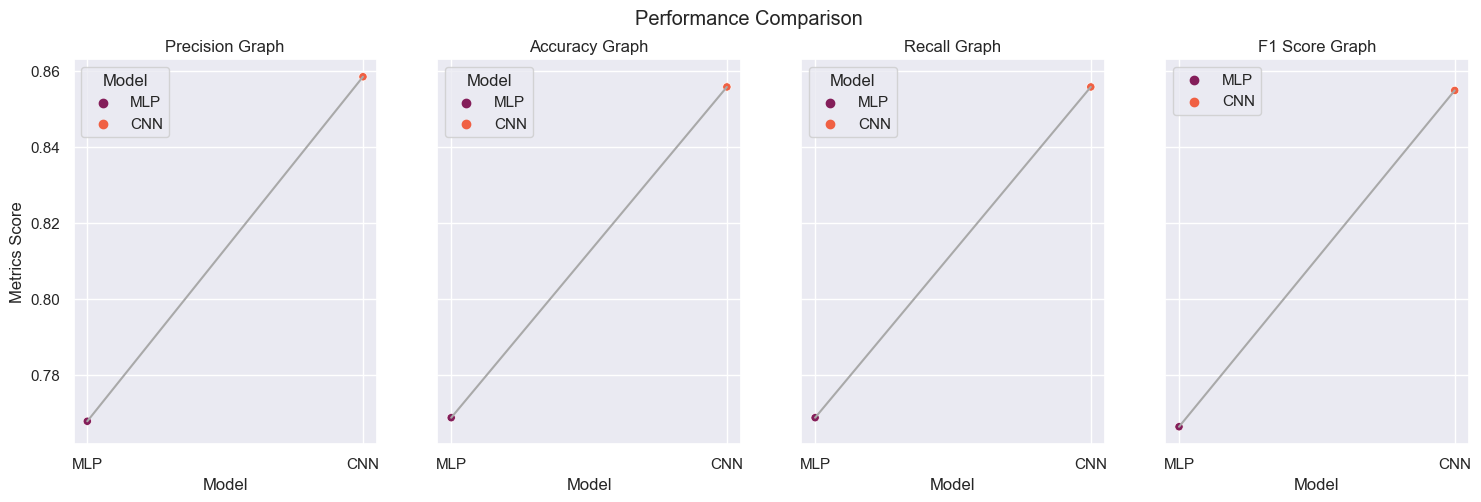

In [61]:
# Plotting the results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 5), sharey=True)
fig.suptitle("Performance Comparison")

sns.scatterplot(ax=ax1, x='Model', y='Precision', data=metrics_df, hue='Model', palette='rocket')
ax1.plot(metrics_df['Model'], metrics_df['Precision'], c='darkgrey')
ax1.set_title('Precision Graph')
ax1.set_ylabel('Metrics Score')

sns.scatterplot(ax=ax2, x='Model', y='Accuracy', data=metrics_df, hue='Model', palette='rocket')
ax2.plot(metrics_df['Model'], metrics_df['Accuracy'], c='darkgrey')
ax2.set_title('Accuracy Graph')

sns.scatterplot(ax=ax3, x='Model', y='Recall', data=metrics_df, hue='Model', palette='rocket')
ax3.plot(metrics_df['Model'], metrics_df['Recall'], c='darkgrey')
ax3.set_title('Recall Graph')

sns.scatterplot(ax=ax4, x='Model', y='F1 Score', data=metrics_df, hue='Model', palette='rocket')
ax4.plot(metrics_df['Model'], metrics_df['F1 Score'], c='darkgrey')
ax4.set_title('F1 Score Graph')

plt.legend()
plt.show()

### CNN significantly outperformed MLP on the EMNIST handwritten digit task. This is because CNNs can automatically learn spatial features from images and are robust to variations, while MLPs struggle with these aspects. The superior performance of the CNN was confirmed by metrics like accuracy, precision, recall and F-score.